In [1]:
import numpy as np
import warnings
import datetime as dt
import yfinance as yfin

import pandas as pd
import pandas_ta as ta
from pandas_datareader import data as pdr

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as p
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import efficient_front as ef
from getBalanceSheet import getBalanceSheet

In [2]:
ticker_list = pd.read_excel("tickers.xlsx")
ticker_list = ticker_list.values.tolist()
ticker_list = [item for sublist in ticker_list for item in sublist]
ticker_list = [f'{ticker}.IS' for ticker in ticker_list]
# ticker_list = ticker_list[21:40]

endDate = dt.datetime.now() - dt.timedelta(days = 0)
startDate = endDate - dt.timedelta(days = 500)

In [3]:
class Technical_Analysis():
    """ This class is created to carry out technical analysis on a given list of tickers
    to find out potential uptrends.
    """
    def __init__(self, ticker_list, start, end, interval):
        self.start = start
        self.end = end
        self.ticker_list = ticker_list
        self.interval = interval

    def getData(self, stocks, start, end, interval = '1d', RSI_len = 22, RSI_len_long = 66, SMA = [], EMA =[]):
        interval = interval
        yfin.pdr_override()
        stockData = pdr.get_data_yahoo(stocks, start=start, end=end, interval = interval)

        df = stockData
        df.ta.rsi(close = df['Close'], length = RSI_len, append = True)
        df.ta.rsi(close = df['Close'], length = RSI_len_long, append = True)

        df.ta.mfi(high = df['High'], low = df['Low'], close = df['Close'], volume = df['Volume'], length=22, append = True)

        df.ta.ema(close = df[f'RSI_{RSI_len_long}'], length = RSI_len_long, append = True)
        df[f'RSI_{RSI_len_long}'] = df[f'EMA_{RSI_len_long}']
        df.drop(f'EMA_{RSI_len_long}', axis='columns', inplace = True)
        # df[f'RSI_{RSI_len_long}'] = df[f'RSI_{RSI_len_long}'].rolling(window=RSI_len_long).mean()
        df.ta.macd(close = df['Close'], fast = 26, slow = 12, signal = 9, append = True)
        for i in range(len(SMA)):
            df.ta.sma(close = df['Close'], length = SMA[i], append = True)
        
        for i in range(len(EMA)):
            df.ta.ema(close = df['Close'], length = EMA[i], append = True)

        
        return df 
    
    def PivotHigh(self, df, window, col = 'RSI_22'):
        df['PIVOT_HIGH'+"_"+col] = 0
        for datapoint in range(df.shape[0]-window):
            index_to_check = datapoint
            window_size = window
            start_index = max(0, index_to_check - window_size)  # Ensure we don't go below 0
            end_index = min(len(df) - 5, index_to_check + window_size)  # Ensure we don't go beyond the DataFrame length, it doesn't look for the last five business days
            subset = df[col][start_index:end_index + 1]  # Select the relevant subset
            # Check if the chosen point is the highest in the subset
            chosen_point_value = df[col][index_to_check]
            if chosen_point_value == subset.max():
                df['PIVOT_HIGH'+"_"+col][datapoint] = 1
            else:
                df['PIVOT_HIGH'+"_"+col][datapoint] = 0
        return df
    
    def RSI_Divergence_Negative(self, price = 'High', interval = '1d', pivot_window = 20, RSI_short_length = 22, RSI_long_length = 66):
    
        ticker_list = self.ticker_list
        startDate = self.start
        endDate = self.end
        interval = self.interval
        
        warnings.filterwarnings('ignore')
        rsi_divergence = []
        RSI_divergence_ratio = []
        Price_divergence_ratio = []
        RSI_short_date1 = []
        RSI_short_date2 = []
        End_of_Trend = []
        RSI_short_date_now = []
        RSI_long = []
        Price_date1 = []
        Price_date2 = []
        Date1 = []
        Date2 = []
        Date_Last = []
        Last_Day_Change = []
        Volatility = []
        MACDh = []
        MFI = []

        window = pivot_window
        interval = interval
        price_l = price
        RSI_len = f'RSI_{RSI_short_length}'
        RSI_len_long = f'RSI_{RSI_long_length}'

        # date_last = dt.datetime.now()

        for stock in ticker_list:
            try:
                df = self.getData(f'{stock}', start = startDate, end = endDate, interval = interval, RSI_len=RSI_short_length, RSI_len_long=RSI_long_length, SMA = [], EMA = [])
                df.dropna(inplace=True)

                df = self.PivotHigh(df, window, RSI_len)
                index_last_1 = df[df[f'PIVOT_HIGH_{RSI_len}']==1].index[-1]
                index_last_2 = df[df[f'PIVOT_HIGH_{RSI_len}']==1].index[-2]
                if df[RSI_len][index_last_1] < df[RSI_len][index_last_2] and df[price_l][index_last_1] > df[price_l][index_last_2]:
                    divergence = 1
                else: 
                    divergence = 0  
                    
                rsi_divergence_r = (df[RSI_len][index_last_1] - df[RSI_len][index_last_2])/df[RSI_len][index_last_2]
                price_divergence_r = (df[price_l][index_last_1] - df[price_l][index_last_2])/df[price_l][index_last_2]
                date1 = index_last_2
                date2 = index_last_1
                date_last = df.index[-1]
                rsi_short_1 = df[RSI_len][index_last_2]
                rsi_short_2 = df[RSI_len][index_last_1]
                rsi_short_date_now = df[RSI_len][-1]
                rsi_long = df[RSI_len_long][index_last_1]
                Price_1 = df[price_l][index_last_2]
                Price_2 = df[price_l][index_last_1]
                Change = df['Close'][-1]/df['Close'][-2]-1
                df['Return'] = df['Close'].pct_change()
                vol = df['Return'].std()
                macdh = df['MACDh_12_26_9'][-1]
                mfi = df['MFI_22'][-1]
                
                y = (rsi_short_2 - rsi_short_1)
                x = np.busday_count(date2.date(), date1.date())
                k = y/x
                new_x = dt.datetime.now()
                delta_x = np.busday_count(new_x.date(), date2.date())
                new_y = delta_x*k+rsi_short_2
                eot = new_y

            except:
                divergence, rsi_divergence_r, price_divergence_r, rsi_short_1, rsi_short_2, rsi_short_date_now, rsi_long, eot, Price_1, Price_2, date1, date2, Change, vol, date_last, macdh, mfi = 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', dt.datetime.now()
                
                
            rsi_divergence.append(divergence)
            RSI_divergence_ratio.append(rsi_divergence_r)
            Price_divergence_ratio.append(price_divergence_r)
            RSI_short_date1.append(rsi_short_1)
            RSI_short_date2.append(rsi_short_2)
            RSI_short_date_now.append(rsi_short_date_now)
            RSI_long.append(rsi_long)
            End_of_Trend.append(eot)
            Price_date1.append(Price_1)
            Price_date2.append(Price_2)
            Date1.append(date1)
            Date2.append(date2)
            Date_Last.append(date_last)
            Last_Day_Change.append(Change)
            Volatility.append(vol)
            MACDh.append(macdh)
            MFI.append(mfi)

        DivergenceList_negative = pd.DataFrame({'Tickers': ticker_list, 
                    'Divergence': rsi_divergence,
                    'RSI Divergence Ratio':RSI_divergence_ratio,
                    'Price Divergence Ratio':Price_divergence_ratio,
                    f'RSI_{RSI_short_length}_Date1':RSI_short_date1,
                    f'RSI_{RSI_short_length}_Date2':RSI_short_date2,
                    f'RSI_{RSI_short_length}_now':RSI_short_date_now,
                    'End_of_RSI_Down_Trend':End_of_Trend,
                    f'RSI_{RSI_long_length}':RSI_long,
                    'Price_Date1':Price_date1,
                    'Price_Date2':Price_date2,
                    'Date1':Date1,
                    'Date2':Date2,
                    'Date_Last':Date_Last,
                    'MACDh':MACDh,
                    'MFI_22':MFI,
                    'Change':Last_Day_Change,
                    'Volatility':Volatility
                    })
        
        DivergenceList_negative.set_index('Tickers', inplace=True) 
        DivergenceList_negative.index.name = 'Tickers'
        DivergenceList_negative = DivergenceList_negative[DivergenceList_negative['Divergence']!='NA']

        # Specify the columns you want to exclude from conversion
        columns_to_exclude = ['Divergence', 'Date1', 'Date2', 'Date_Last']

        # Convert all other columns to float
        columns_to_convert = [col for col in DivergenceList_negative.columns if col not in columns_to_exclude]
        DivergenceList_negative[columns_to_convert] = DivergenceList_negative[columns_to_convert].astype(float)
        DivergenceList_negative['Divergence'] = DivergenceList_negative['Divergence'].astype(int)

        columns_to_convert_to_datetime = ['Date1', 'Date2', 'Date_Last']
        DivergenceList_negative[columns_to_convert_to_datetime] = DivergenceList_negative[columns_to_convert_to_datetime].apply(pd.to_datetime)
        DivergenceList_negative['RSI_EOT_Ratio'] = (DivergenceList_negative['RSI_22_now'] - DivergenceList_negative['End_of_RSI_Down_Trend'])/DivergenceList_negative['End_of_RSI_Down_Trend']
        self.DivergenceList_negative = DivergenceList_negative
        
        # return self.DivergenceList_negative

    def RSI_Divergence_Negative_func(self, df, start, end, price = 'High', interval = '1d', pivot_window = 20, RSI_short_length = 22, RSI_long_length = 66, RSI_EOT_diff = -0.02):
    
        ticker_list = df
        startDate = start
        endDate = end
        interval = self.interval

        warnings.filterwarnings('ignore')
        rsi_divergence = []
        RSI_divergence_ratio = []
        Price_divergence_ratio = []
        RSI_short_date1 = []
        RSI_short_date2 = []
        End_of_Trend = []
        RSI_short_date_now = []
        RSI_long = []
        Price_date1 = []
        Price_date2 = []
        Date1 = []
        Date2 = []
        Date_Last = []
        Last_Day_Change = []
        Volatility = []
        MACDh = []
        MFI = []
        

        window = pivot_window
        interval = interval
        price_l = price
        RSI_len = f'RSI_{RSI_short_length}'
        RSI_len_long = f'RSI_{RSI_long_length}'

        # date_last = dt.datetime.now()

        for stock in ticker_list:
            try:
                df = self.getData(f'{stock}', start = startDate, end = endDate, interval = interval, RSI_len=RSI_short_length, RSI_len_long=RSI_long_length, SMA = [])
                df.dropna(inplace=True)

                df = self.PivotHigh(df, window, RSI_len)
                index_last_1 = df[df[f'PIVOT_HIGH_{RSI_len}']==1].index[-1]
                index_last_2 = df[df[f'PIVOT_HIGH_{RSI_len}']==1].index[-2]
                if df[RSI_len][index_last_1] < df[RSI_len][index_last_2] and df[price_l][index_last_1] > df[price_l][index_last_2]:
                    divergence = 1
                else: 
                    divergence = 0  
                    
                rsi_divergence_r = (df[RSI_len][index_last_1] - df[RSI_len][index_last_2])/df[RSI_len][index_last_2]
                price_divergence_r = (df[price_l][index_last_1] - df[price_l][index_last_2])/df[price_l][index_last_2]
                date1 = index_last_2
                date2 = index_last_1
                date_last = df.index[-1]
                rsi_short_1 = df[RSI_len][index_last_2]
                rsi_short_2 = df[RSI_len][index_last_1]
                rsi_short_date_now = df[RSI_len][-1]
                rsi_long = df[RSI_len_long][index_last_1]
                Price_1 = df[price_l][index_last_2]
                Price_2 = df[price_l][index_last_1]
                Change = df['Close'][-1]/df['Close'][-2]-1
                df['Return'] = df['Close'].pct_change()
                vol = df['Return'].std()
                macdh = df['MACDh_12_26_9'][-1]
                mfi = df['MFI_22'][-1]
                
                y = (rsi_short_2 - rsi_short_1)
                x = np.busday_count(date2.date(), date1.date())
                k = y/x
                new_x = dt.datetime.now()
                delta_x = np.busday_count(new_x.date(), date2.date())
                new_y = delta_x*k+rsi_short_2
                eot = new_y

            except:
                divergence, rsi_divergence_r, price_divergence_r, rsi_short_1, rsi_short_2, rsi_short_date_now, rsi_long, eot, Price_1, Price_2, date1, date2, Change, vol, date_last, macdh, mfi = 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', dt.datetime.now()
                
                
            rsi_divergence.append(divergence)
            RSI_divergence_ratio.append(rsi_divergence_r)
            Price_divergence_ratio.append(price_divergence_r)
            RSI_short_date1.append(rsi_short_1)
            RSI_short_date2.append(rsi_short_2)
            RSI_short_date_now.append(rsi_short_date_now)
            RSI_long.append(rsi_long)
            End_of_Trend.append(eot)
            Price_date1.append(Price_1)
            Price_date2.append(Price_2)
            Date1.append(date1)
            Date2.append(date2)
            Date_Last.append(date_last)
            Last_Day_Change.append(Change)
            Volatility.append(vol)
            MACDh.append(macdh)
            MFI.append(mfi)

        DivergenceList_negative = pd.DataFrame({'Tickers': ticker_list, 
                    'Divergence': rsi_divergence,
                    'RSI Divergence Ratio':RSI_divergence_ratio,
                    'Price Divergence Ratio':Price_divergence_ratio,
                    f'RSI_{RSI_short_length}_Date1':RSI_short_date1,
                    f'RSI_{RSI_short_length}_Date2':RSI_short_date2,
                    f'RSI_{RSI_short_length}_now':RSI_short_date_now,
                    'End_of_RSI_Down_Trend':End_of_Trend,
                    f'RSI_{RSI_long_length}':RSI_long,
                    'Price_Date1':Price_date1,
                    'Price_Date2':Price_date2,
                    'Date1':Date1,
                    'Date2':Date2,
                    'Date_Last':date_last,
                    'MACDh':MACDh,
                    'MFI_22':MFI,
                    'Change':Last_Day_Change,
                    'Volatility':Volatility
                    })
        
        DivergenceList_negative.set_index('Tickers', inplace=True) 
        DivergenceList_negative.index.name = 'Tickers'
        DivergenceList_negative = DivergenceList_negative[DivergenceList_negative['Divergence']!='NA']

        # Specify the columns you want to exclude from conversion
        columns_to_exclude = ['Divergence', 'Date1', 'Date2', 'Date_Last']

        # Convert all other columns to float
        columns_to_convert = [col for col in DivergenceList_negative.columns if col not in columns_to_exclude]
        DivergenceList_negative[columns_to_convert] = DivergenceList_negative[columns_to_convert].astype(float)
        DivergenceList_negative['Divergence'] = DivergenceList_negative['Divergence'].astype(int)

        columns_to_convert_to_datetime = ['Date1', 'Date2', 'Date_Last']
        DivergenceList_negative[columns_to_convert_to_datetime] = DivergenceList_negative[columns_to_convert_to_datetime].apply(pd.to_datetime)
        DivergenceList_negative['RSI_EOT_Ratio'] = (DivergenceList_negative['RSI_22_now'] - DivergenceList_negative['End_of_RSI_Down_Trend'])/DivergenceList_negative['End_of_RSI_Down_Trend']
        
        return DivergenceList_negative

    def getRawData(self, stocks, start, end):
        start = start
        end = end
        interval = self.interval
        stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
        stockData = stockData['Close']

        returns = stockData.pct_change()
        meanReturns = returns.mean()
        try:
            covMatrix = returns.cov()
        except:
            covMatrix = None

        return meanReturns, covMatrix

    def portfolioReturn(self, ticker_list, ticker_ratio, start, end, interval):
        p_return = 0
        returns = []
        change_list = []
        interval = self.interval
        for stock, ratio in zip(ticker_list, ticker_ratio):
            df = pdr.get_data_yahoo(f'{stock}', start=start, end=end, interval = interval)
            change = df['Close'][-1]/df['Close'][-2]
            returns.append(change*ratio/100)
            change_list.append(change)
            p_return += change*ratio/100
        # p_return = p_return/len(returns)
        return p_return, returns, change_list

    def DivergenceList_negative_watchlist(self, RSI_EOT_diff_more = -0.02, RSI_EOT_diff_less = 0, price = 'High', interval = '1d', 
                                          pivot_window = 20, RSI_short_length = 22, RSI_long_length = 66, change_more = -0.1, change_less = 0.1, macdh_more = 0,
                                          rsi_divergence_less = 0, price_divergence_more = 0, rsi_break = True):
        DivergenceList_negative = self.DivergenceList_negative
        start = self.start
        end = self.end
        interval = self.interval
        # end = np.busday_offset(self.end.date(), 1).astype(dt.datetime)
        # DivergenceList_negative['RSI_EOT_Ratio'] = (DivergenceList_negative['RSI_22_now'] - DivergenceList_negative['End_of_RSI_Down_Trend'])/DivergenceList_negative['End_of_RSI_Down_Trend']
        f1 = (DivergenceList_negative['Divergence']==1)
        f2 = (DivergenceList_negative['RSI_EOT_Ratio']<RSI_EOT_diff_less)
        f3 = (DivergenceList_negative['RSI_EOT_Ratio']>RSI_EOT_diff_more)
        f4 = (DivergenceList_negative['Change']>change_more)
        f5 = (DivergenceList_negative['Change']<change_less)
        f6 = (DivergenceList_negative['RSI Divergence Ratio']<rsi_divergence_less)
        f7 = (DivergenceList_negative['Price Divergence Ratio']>price_divergence_more)
        f8 = (DivergenceList_negative[f'RSI_{RSI_short_length}_now']>DivergenceList_negative[f'RSI_{RSI_long_length}'])
        f9 = (DivergenceList_negative['MACDh']>macdh_more)
        if rsi_break == True:
            todays_watchlist = DivergenceList_negative[f1 & f2 & f3 & f4 & f5 & f6 & f7 & f8 & f9].sort_values('RSI Divergence Ratio', ascending=True).index
        else: 
            todays_watchlist = DivergenceList_negative[f1 & f2 & f3 & f4 & f5 & f6 & f7 & f9].sort_values('RSI Divergence Ratio', ascending=True).index

        todays_signals = self.RSI_Divergence_Negative_func(todays_watchlist, start = start, end = end, price = price, interval=interval, pivot_window = pivot_window, RSI_short_length = RSI_short_length, RSI_long_length = RSI_long_length)

        todays_watchlist = [f'{ticker}' for ticker in todays_watchlist]
        # mean_return, cov_matrix = getRawData(todays_watchlist, start, end)
        last_return = todays_signals['Change']

        c = len(todays_signals['Volatility'])
        weights = np.ones(c)/c
        # if cov_matrix != None:
        #     portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        #     portfolio_return = np.dot(weights, mean_return)
        # else:
        #     portfolio_volatility = None
        #     portfolio_return = None

        portfolio_last_day_return = np.dot(weights, last_return)
        # print("Portfolio Volatility: ", portfolio_volatility)
        # print("Portfolio Return: ", portfolio_return)
        print("Portfolio today Return: ", portfolio_last_day_return)

        cm = sns.blend_palette(['red', 'yellow', 'green'], n_colors = 3, as_cmap=True)
        
        # return todays_signals.style.background_gradient(cmap=cm), portfolio_last_day_return
        return todays_signals, portfolio_last_day_return
        
    def backtest_results_stats(df):

        return_by_day = df

        print(stats.describe(return_by_day))

        # Initialize counters for negative and positive values
        positive_count = 0
        negative_count = 0
        positive_yield = 1
        negative_yield = 1

        # Iterate through the list
        for value in return_by_day:
            if value-1 > 0:
                positive_count += 1
                positive_yield *= value
            elif value-1 < 0:
                negative_count += 1
                negative_yield *= value

        # Print the counts
        print("Positive Count:", positive_count)
        print("Negative Count:", negative_count)
        print("Positive Yield:", positive_yield)
        print("Negative Yield:", negative_yield)
    
    def VolumeProfile(self, ticker, start, end, interval, range, width):
        interval = self.interval
        df = self.getData(ticker, start, end, interval = interval)

        vpdf = df.tail(range) # Take the last 30 Daily Bars
        vp = vpdf.ta.vp(width = width) # Run Volume Profile
        # print("Returns unsorted close\n", vp, "\n") # Visual Table Check

        # Set the index to mean_close and in ascending order
        vp['mean_close'] = round(vp['mean_Close'], 2)
        vp.set_index('mean_Close', inplace=True)
        vp.sort_index(ascending=True, inplace=True)
        vp.index = np.round(vp.index,2)
        # print("Sorted by mean_close\n", vp, "\n") # Visual Table Check

        # Take the last three columns and plot them with horizontal bars
        # Create a horizontal stacked bar chart
        # Create a horizontal stacked bar chart
        ax = vp[vp.columns[-3:]].plot(
            kind='barh',
            figsize=(5, 8),
            title=f"{ticker} Volume Profile (Recent {range} Days)",
            color=['red', 'green', 'silver'],
            alpha=0.45,
            stacked=True,
        )

        # Move the legend to the right of the plot
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

        # Calculate the maximum value to set the x-axis limit
        max_value = vp[vp.columns[-3:]].sum(axis=1).max()

        # Create a gap by adjusting the x-axis limits
        ax.set_xlim(0, max_value + 5)  # Add a small gap (5) to the right side of the longest bar

        plt.show()
    
    # Plot the Stock Data with Indicators
def Candle_graph(df, date1, date2, price = 'High'):
    import random
    import holidays
    ema_columns = [col for col in df.columns if "EMA" in col]
    sma_columns = [col for col in df.columns if "SMA" in col]
    rsi_columns = [col for col in df.columns if "RSI" in col]
    
    change = round(((df['Close'][-1]/df['Close'][-2])-1)*100, 2)
    # change_sign = change > 0
    # change_sign = change_sign.astype(int)
    high = round(df['High'][-1],2)
    low = round(df['Low'][-1],2)
    open = round(df['Open'][-1],2)
    close = round(df['Close'][-1],2)
    volume = round(df['Volume'][-1]/1000000,2)
    mfi_22 = round(df["MFI_22"][-1], 2)
    date = df.index[-1]

    fig = make_subplots(rows=5, cols=1, row_heights = [0.6, 0.2, 0.2, 0.2, 0.2])

    fig.add_trace(
        go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close']), 
                row = 1, col = 1)
    fig.update_traces(name='Stock')

    if date1 != None:
        date_last = dt.datetime.now()
        y = (df.loc[date2, price] - df.loc[date1, price])
        x = np.busday_count(date2.date(), date1.date())
        k = y/x
        new_x = dt.datetime.now()
        delta_x = np.busday_count(new_x.date(), date2.date())
        price_last = delta_x*k+df.loc[date2, price]

        date12 = [date1, date2, date_last]
        y12 = [df.loc[date1, price], df.loc[date2, price], price_last]

        fig.add_trace(
            go.Scatter(
            name='Price Up Trend',
            mode='lines',
            x = date12,
            y = y12,
            line=dict(color='red', width=1, dash='solid')), 
            row = 1, col = 1)


    fig.add_trace(
        go.Bar(
        name='Volume',
        # mode='lines',
        x = df.index,
        y = df['Volume'],
        marker_color = df['Volume']), 
        row = 2, col = 1)
    
    fig.add_annotation(xref='x domain',
                   yref='y domain',
                   x=0.01,
                   y=0.99,
                   text='Change: ' + f'%{change}', 
                   showarrow=False,
                   row=1, col=1)
    
    fig.add_annotation(xref='x domain',
                   yref='y domain',
                   x=0.01,
                   y=0.93,
                   text='High:      ' + f'{high}', 
                   showarrow=False,
                   row=1, col=1)

    fig.add_annotation(xref='x domain',
                   yref='y domain',
                   x=0.01,
                   y=0.87,
                   text='Low:       ' + f'{low}', 
                   showarrow=False,
                   row=1, col=1)
    
    fig.add_annotation(xref='x domain',
                   yref='y domain',
                   x=0.01,
                   y=0.81,
                   text='Open:     ' + f'{open}', 
                   showarrow=False,
                   row=1, col=1)
    
    fig.add_annotation(xref='x domain',
                   yref='y domain',
                   x=0.01,
                   y=0.75,
                   text='Close:     ' + f'{close}', 
                   showarrow=False,
                   row=1, col=1)
    
    fig.add_annotation(xref='x domain',
                   yref='y domain',
                   x=0.01,
                   y=0.69,
                   text='Date:     ' + f'{date}', 
                   showarrow=False,
                   row=1, col=1)
    
    fig.add_annotation(xref='x domain',
                   yref='y domain',
                   x=0.01,
                   y=0.99,
                   text='Volume: ' + f'{volume} million', 
                   showarrow=False,
                   row=2, col=1)
    
    fig.add_annotation(xref='x domain',
                   yref='y domain',
                   x=0.01,
                   y=0.99,
                   text=f'{rsi_columns[0]}: ' + f'{np.round(df[rsi_columns[0]][-1],0)}', 
                   showarrow=False,
                   row=3, col=1)
    
    fig.add_annotation(xref='x domain',
                yref='y domain',
                x=0.01,
                y=0.81,
                text=f'{rsi_columns[1]}: ' + f'{np.round(df[rsi_columns[1]][-1],0)}', 
                showarrow=False,
                row=3, col=1)
    
    fig.add_annotation(xref='x domain',
                yref='y domain',
                x=0.01,
                y=0.81,
                text='MFI: ' + f'{mfi_22}', 
                showarrow=False,
                row=5, col=1)


    for col in sma_columns:
        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)
        color_code = "#{:02x}{:02x}{:02x}".format(red, green, blue)
        fig.add_trace(
            go.Scatter(
            name=col,
            mode='lines',
            x = df.index,
            y = df[col],
            line=dict(color=color_code, width=2, dash='solid')), 
            row = 1, col = 1)

    for col in ema_columns:
        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)
        color_code = "#{:02x}{:02x}{:02x}".format(red, green, blue)
        fig.add_trace(
            go.Scatter(
            name=col,
            mode='lines',
            x = df.index,
            y = df[col],
            line=dict(color=color_code, width=2, dash='solid')), 
            row = 1, col = 1)
    
    fig.add_trace(
        go.Scatter(
        name='RSI22',
        mode='lines',
        x = df.index,
        y = df['RSI_22'],
        line=dict(color='green', width=2, dash='solid')), 
        row = 3, col = 1)
    
    fig.add_trace(
        go.Scatter(
        name='RSI66',
        mode='lines',
        x = df.index,
        y = df['RSI_66'],
        line=dict(color='red', width=2, dash='solid')), 
        row = 3, col = 1)
    

    if date1 != None:
        date_last = dt.datetime.now()
        y = (df.loc[date2, 'RSI_22'] - df.loc[date1, 'RSI_22'])
        x = np.busday_count(date2.date(), date1.date())
        k = y/x
        new_x = dt.datetime.now()
        delta_x = np.busday_count(new_x.date(), date2.date())
        rsi_last = delta_x*k+df.loc[date2, 'RSI_22']

        date12 = [date1, date2, date_last]
        y12 = [df.loc[date1, 'RSI_22'], df.loc[date2, 'RSI_22'], rsi_last]


        fig.add_trace(
            go.Scatter(
            name='RSI22 Down Trend',
            mode='lines',
            x = date12,
            y = y12,
            line=dict(color='red', width=1, dash='solid')), 
            row = 3, col = 1)
    
    fig.add_trace(
        go.Scatter(
        name='MACD 26 12',
        mode='lines',
        x = df.index,
        y = df['MACD_12_26_9'],
        line=dict(color='green', width=2, dash='solid')), 
        row = 4, col = 1)
    
    fig.add_trace(
        go.Scatter(
        name='MACD Signal',
        mode='lines',
        x = df.index,
        y = df['MACDs_12_26_9'],
        line=dict(color='orange', width=2, dash='solid')), 
        row = 4, col = 1)
    
    fig.add_trace(
        go.Bar(
        name='MACD Diff',
        # mode='lines',
        x = df.index,
        y = df['MACDh_12_26_9'],
        marker_color = df['MACDh_12_26_9']), 
        row = 4, col = 1)
    
    fig.add_trace(
        go.Scatter(
        name='MFI_22',
        mode='lines',
        x = df.index,
        y = df['MFI_22'],
        marker_color = df['MFI_22']), 
        row = 5, col = 1)
    
    
    fig.update_layout(
        yaxis = dict(title='Price'),
        width=1400,
        height=900,
        xaxis_rangeslider_visible = False)    
    
    
    hldays = []
    for holiday in holidays.Turkey(years = [(df.index[0]).year, (df.index[-1]).year]).items():
        hldays.append(holiday[0])

    fig.update_xaxes(
    rangebreaks=[
        dict(bounds = ["sat", "mon"]), #hide weekends
        dict(values = hldays)  # hide holidays
    ]
    )
    
    return fig.show()


In [4]:
class Backtest():
    def __init__(self, ticker_list, start, end):
        self.start = start
        self.end = end
        self.ticker_list = ticker_list
    
    def getData(self, stocks, start, end, interval = '1d', RSI_len = 22, RSI_len_long = 66, SMA = [], EMA =[]):
        
        yfin.pdr_override()
        stockData = pdr.get_data_yahoo(stocks, start=start, end=end, interval = interval)

        df = stockData

        df.ta.rsi(close = df['Close'], length = RSI_len, append = True)
        df.ta.rsi(close = df['Close'], length = RSI_len_long, append = True)
        df.ta.ema(close = df[f'RSI_{RSI_len_long}'], length = RSI_len_long, append = True)
        df[f'RSI_{RSI_len_long}'] = df[f'EMA_{RSI_len_long}']
        df.drop(f'EMA_{RSI_len_long}', axis='columns', inplace = True)
        # df[f'RSI_{RSI_len_long}'] = df[f'RSI_{RSI_len_long}'].rolling(window=RSI_len_long).mean()
        df.ta.macd(close = df['Close'], fast = 26, slow = 12, signal = 9, append = True)
        for i in range(len(SMA)):
            df.ta.sma(close = df['Close'], length = SMA[i], append = True)
        
        for i in range(len(EMA)):
            df.ta.sma(close = df['Close'], length = EMA[i], append = True)

        
        return df 
    
    def PivotHigh(self, df, window, col = 'RSI_22'):
        df['PIVOT_HIGH'+"_"+col] = 0
        for datapoint in range(df.shape[0]):
            index_to_check = datapoint
            window_size = window
            start_index = max(0, index_to_check - window_size)  # Ensure we don't go below 0
            end_index = min(len(df), index_to_check + window_size)  # Ensure we don't go beyond the DataFrame length
            subset = df[col][start_index:end_index + 1]  # Select the relevant subset
            # Check if the chosen point is the highest in the subset
            chosen_point_value = df[col][index_to_check]
            if chosen_point_value == subset.max():
                df['PIVOT_HIGH'+"_"+col][datapoint] = 1
            else:
                df['PIVOT_HIGH'+"_"+col][datapoint] = 0
        return df
    
    def backtest_df(self, price = 'High', interval = '1d', pivot_window = 20, RSI_short_length = 22, RSI_long_length = 66, dateback = 30):
        """
        For backtesting the algorithm. It ends 1 day before original endDate of the object.
        """

        ticker_list = self.ticker_list
        # Create an empty dictionary to store DataFrames
        results = {}
        startDate = self.start
        endDate = self.end

        for i in range(1, dateback + 1):
            results[i] = pd.DataFrame({'Tickers':ticker_list, 
                    'Divergence':np.zeros(len(ticker_list)),
                    'RSI Divergence Ratio':np.zeros(len(ticker_list)),
                    'Price Divergence Ratio':np.zeros(len(ticker_list)),
                    f'RSI_{RSI_short_length}_Date1':np.zeros(len(ticker_list)),
                    f'RSI_{RSI_short_length}_Date2':np.zeros(len(ticker_list)),
                    f'RSI_{RSI_short_length}_now':np.zeros(len(ticker_list)),
                    'End_of_RSI_Down_Trend':np.zeros(len(ticker_list)),
                    f'RSI_{RSI_long_length}':np.zeros(len(ticker_list)),
                    'Price_Date1':np.zeros(len(ticker_list)),
                    'Price_Date2':np.zeros(len(ticker_list)),
                    'Date_Last':np.full(len(ticker_list), dt.datetime.now()),
                    # 'Date1':np.full(len(ticker_list), dt.datetime.now()),
                    # 'Date2':np.full(len(ticker_list), dt.datetime.now()),
                    'Date1':np.zeros(len(ticker_list)),
                    'Date2':np.zeros(len(ticker_list)),
                    'Date_Last':np.zeros(len(ticker_list)),
                    'Change':np.zeros(len(ticker_list)),
                    'Volatility':np.zeros(len(ticker_list))
                    })
            results[i] = results[i].set_index('Tickers')

        warnings.filterwarnings('ignore')
        window = pivot_window
        interval = interval
        price_l = price
        RSI_len = f'RSI_{RSI_short_length}'
        RSI_len_long = f'RSI_{RSI_long_length}'

        for stock in ticker_list:
            try:
                df_ = self.getData(f'{stock}.IS', start = startDate, end = endDate, interval = interval, RSI_len=RSI_short_length, RSI_len_long=RSI_long_length, SMA = [])
                # df_ = self.getData(stock+".IS", interval = interval, RSI_len=RSI_short_length, RSI_len_long=RSI_long_length, SMA = [200, 50, 5, 9])
                df_.dropna(inplace=True)
                
                for j in range(-1, -dateback-1, -1):
                    df = df_.iloc[:j, :]
                    df = self.PivotHigh(df, window, RSI_len)
                    index_last_1 = df[df[f'PIVOT_HIGH_{RSI_len}']==1].index[-1]
                    index_last_2 = df[df[f'PIVOT_HIGH_{RSI_len}']==1].index[-2]
                    if df[RSI_len][index_last_1] < df[RSI_len][index_last_2] and df[price_l][index_last_1] > df[price_l][index_last_2]:
                        divergence = 1
                    else: 
                        divergence = 0  
                        
                    rsi_divergence_r = (df[RSI_len][index_last_1] - df[RSI_len][index_last_2])/df[RSI_len][index_last_2]
                    price_divergence_r = (df[price_l][index_last_1] - df[price_l][index_last_2])/df[price_l][index_last_2]
                    date1 = index_last_2
                    date2 = index_last_1
                    date_last = df.index[-1]
                    rsi_short_1 = df[RSI_len][index_last_2]
                    rsi_short_2 = df[RSI_len][index_last_1]
                    rsi_short_date_now = df[RSI_len][-2]
                    rsi_long = df[RSI_len_long][index_last_1]
                    Price_1 = df[price_l][index_last_2]
                    Price_2 = df[price_l][index_last_1]
                    # Change = df['Close'][-1]/df['Close'][-2]-1
                    Change = df['Close'].pct_change()[-1]
                    df['Return'] = df['Close'].pct_change()
                    vol = df['Return'].std()
                    
                    y = (rsi_short_2 - rsi_short_1)
                    x = np.busday_count(date2.date(), date1.date())
                    k = y/x
                    new_x = dt.datetime.now()
                    delta_x = np.busday_count(new_x.date(), date2.date())
                    new_y = delta_x*k+rsi_short_2
                    eot = new_y

                    results[-j].loc[stock]['Divergence'] = divergence
                    results[-j].loc[stock]['RSI Divergence Ratio'] = rsi_divergence_r
                    results[-j].loc[stock]['Price Divergence Ratio'] = price_divergence_r
                    results[-j].loc[stock][f'RSI_{RSI_short_length}_Date1'] = rsi_short_1
                    results[-j].loc[stock][f'RSI_{RSI_short_length}_Date2'] = rsi_short_2
                    results[-j].loc[stock][f'RSI_{RSI_short_length}_now'] = rsi_short_date_now
                    results[-j].loc[stock]['End_of_RSI_Down_Trend'] = eot
                    results[-j].loc[stock][f'RSI_{RSI_long_length}'] = rsi_long
                    results[-j].loc[stock]['Price_Date1'] = Price_1
                    results[-j].loc[stock]['Price_Date2'] = Price_2
                    results[-j].loc[stock]['Date1'] = date1
                    results[-j].loc[stock]['Date2'] = date2
                    results[-j].loc[stock]['Date_Last'] = date_last
                    results[-j].loc[stock]['Change'] = Change
                    results[-j].loc[stock]['Volatility'] = vol

            except:
                pass
            self.results = results
        return self.results

    def backtest_return(self, RSI_more = -0.2, RSI_less = 0.2, change_more = -0.1, change_less = 0.1):
        results = self.results
        daily_return = []
        for i in range(len(results)):
            results[i+1]['RSI_EOT_Ratio'] = (results[i+1]['RSI_22_now'] - results[i+1]['End_of_RSI_Down_Trend'])/results[i+1]['End_of_RSI_Down_Trend']

        ret = 1
        for j in range(len(results)):
            df = results[j+1]
            f1 = (df['Divergence']==1)
            f2 = (df['RSI_EOT_Ratio']>RSI_more)
            f3 = (df['RSI_EOT_Ratio']<RSI_less)
            f4 = (df['Change']>change_more)
            f5 = (df['Change']<change_less)
            df = df[f1 & f2 & f3 & f4 & f5]
            r = 0
            for c in df['Change']:
                r = (c+1)+r
            if df.shape[0] != 0:
                r = r/df.shape[0]
            else:
                r = 1
            ret = ret * r
            daily_return.append(ret)
        return ret, daily_return
    
    def RSI_Divergence_Negative(self, start, end, price = 'High', interval = '1d', pivot_window = 20, RSI_short_length = 22, RSI_long_length = 66):
    
        ticker_list = self.ticker_list
        startDate = start
        endDate = end
        
        warnings.filterwarnings('ignore')
        rsi_divergence = []
        RSI_divergence_ratio = []
        Price_divergence_ratio = []
        RSI_short_date1 = []
        RSI_short_date2 = []
        End_of_Trend = []
        RSI_short_date_now = []
        RSI_long = []
        Price_date1 = []
        Price_date2 = []
        Date1 = []
        Date2 = []
        Date_Last = []
        Last_Day_Change = []
        Volatility = []

        window = pivot_window
        interval = interval
        price_l = price
        RSI_len = f'RSI_{RSI_short_length}'
        RSI_len_long = f'RSI_{RSI_long_length}'

        # date_last = dt.datetime.now()

        for stock in ticker_list:
            try:
                df = self.getData(f'{stock}.IS', start = startDate, end = endDate, interval = interval, RSI_len=RSI_short_length, RSI_len_long=RSI_long_length, SMA = [], EMA = [])
                df.dropna(inplace=True)

                df = self.PivotHigh(df, window, RSI_len)
                index_last_1 = df[df[f'PIVOT_HIGH_{RSI_len}']==1].index[-1]
                index_last_2 = df[df[f'PIVOT_HIGH_{RSI_len}']==1].index[-2]
                if df[RSI_len][index_last_1] < df[RSI_len][index_last_2] and df[price_l][index_last_1] > df[price_l][index_last_2]:
                    divergence = 1
                else: 
                    divergence = 0  
                    
                rsi_divergence_r = (df[RSI_len][index_last_1] - df[RSI_len][index_last_2])/df[RSI_len][index_last_2]
                price_divergence_r = (df[price_l][index_last_1] - df[price_l][index_last_2])/df[price_l][index_last_2]
                date1 = index_last_2
                date2 = index_last_1
                date_last = df.index[-1]
                rsi_short_1 = df[RSI_len][index_last_2]
                rsi_short_2 = df[RSI_len][index_last_1]
                rsi_short_date_now = df[RSI_len][-1]
                rsi_long = df[RSI_len_long][index_last_1]
                Price_1 = df[price_l][index_last_2]
                Price_2 = df[price_l][index_last_1]
                Change = df['Close'][-1]/df['Close'][-2]-1
                df['Return'] = df['Close'].pct_change()
                vol = df['Return'].std()
                
                y = (rsi_short_2 - rsi_short_1)
                x = np.busday_count(date2.date(), date1.date())
                k = y/x
                new_x = dt.datetime.now()
                delta_x = np.busday_count(new_x.date(), date2.date())
                new_y = delta_x*k+rsi_short_2
                eot = new_y

            except:
                divergence, rsi_divergence_r, price_divergence_r, rsi_short_1, rsi_short_2, rsi_short_date_now, rsi_long, eot, Price_1, Price_2, date1, date2, Change, vol, date_last = 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', dt.datetime.now()
                
                
            rsi_divergence.append(divergence)
            RSI_divergence_ratio.append(rsi_divergence_r)
            Price_divergence_ratio.append(price_divergence_r)
            RSI_short_date1.append(rsi_short_1)
            RSI_short_date2.append(rsi_short_2)
            RSI_short_date_now.append(rsi_short_date_now)
            RSI_long.append(rsi_long)
            End_of_Trend.append(eot)
            Price_date1.append(Price_1)
            Price_date2.append(Price_2)
            Date1.append(date1)
            Date2.append(date2)
            Date_Last.append(date_last)
            Last_Day_Change.append(Change)
            Volatility.append(vol)

        DivergenceList_negative = pd.DataFrame({'Tickers': ticker_list, 
                    'Divergence': rsi_divergence,
                    'RSI Divergence Ratio':RSI_divergence_ratio,
                    'Price Divergence Ratio':Price_divergence_ratio,
                    f'RSI_{RSI_short_length}_Date1':RSI_short_date1,
                    f'RSI_{RSI_short_length}_Date2':RSI_short_date2,
                    f'RSI_{RSI_short_length}_now':RSI_short_date_now,
                    'End_of_RSI_Down_Trend':End_of_Trend,
                    f'RSI_{RSI_long_length}':RSI_long,
                    'Price_Date1':Price_date1,
                    'Price_Date2':Price_date2,
                    'Date1':Date1,
                    'Date2':Date2,
                    'Date_Last':Date_Last,
                    'Change':Last_Day_Change,
                    'Volatility':Volatility
                    })
        
        DivergenceList_negative.set_index('Tickers', inplace=True) 
        DivergenceList_negative.index.name = 'Tickers'
        DivergenceList_negative = DivergenceList_negative[DivergenceList_negative['Divergence']!='NA']

        # Specify the columns you want to exclude from conversion
        columns_to_exclude = ['Divergence', 'Date1', 'Date2', 'Date_Last']

        # Convert all other columns to float
        columns_to_convert = [col for col in DivergenceList_negative.columns if col not in columns_to_exclude]
        DivergenceList_negative[columns_to_convert] = DivergenceList_negative[columns_to_convert].astype(float)
        DivergenceList_negative['Divergence'] = DivergenceList_negative['Divergence'].astype(int)

        columns_to_convert_to_datetime = ['Date1', 'Date2', 'Date_Last']
        DivergenceList_negative[columns_to_convert_to_datetime] = DivergenceList_negative[columns_to_convert_to_datetime].apply(pd.to_datetime)
        DivergenceList_negative['RSI_EOT_Ratio'] = (DivergenceList_negative['RSI_22_now'] - DivergenceList_negative['End_of_RSI_Down_Trend'])/DivergenceList_negative['End_of_RSI_Down_Trend']
        
        return DivergenceList_negative

In [5]:
str1 = Technical_Analysis(ticker_list=ticker_list, start=startDate, end=endDate, interval = '1d')
str1.RSI_Divergence_Negative(price = 'High', pivot_window = 10, RSI_short_length = 22, RSI_long_length = 66)
# str1.DivergenceList_negative_watchlist(RSI_EOT_diff=-0.5)[0]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [6]:
R_more = -0.5
R_less = 0
change_more = -0.00001
change_less = 0.10
rsi_divergence_less = 0
price_divergence_more = 0
macdh_more = -0.5

res = str1.DivergenceList_negative_watchlist(RSI_EOT_diff_more = R_more, RSI_EOT_diff_less = R_less, change_more=change_more, change_less = change_less, pivot_window=10,
                                             rsi_divergence_less = rsi_divergence_less, price_divergence_more = price_divergence_more, rsi_break=True, macdh_more = macdh_more)[0]
tickers = res.index
# tickers = [stock for stock in tickers]
meanReturns, covMatrix = ef.getData(tickers.to_list(), start = startDate, end = endDate)
res

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Portfolio today Return:  0.060236411894774966
[*********************100%%**********************]  7 of 7 completed


,Divergence,RSI Divergence Ratio,Price Divergence Ratio,RSI_22_Date1,RSI_22_Date2,RSI_22_now,End_of_RSI_Down_Trend,RSI_66,Price_Date1,Price_Date2,Date1,Date2,Date_Last,MACDh,MFI_22,Change,Volatility,RSI_EOT_Ratio
Tickers,,,,,,,,,,,,,,,,,,
KFEIN.IS,1,-0.051887,0.459799,78.899204,74.805380,66.331877,69.719115,58.707788,39.799999,58.099998,2023-08-21,2023-10-05,2023-11-30,1.030514,67.312036,0.024373,0.037793,-0.048584
POLTK.IS,1,-0.044841,0.866976,88.274860,84.316512,72.070565,81.869534,64.146993,6479.299805,12096.700195,2023-07-31,2023-10-16,2023-11-30,435.703890,56.992712,0.055854,0.051428,-0.119690
KONYA.IS,1,-0.019948,0.419236,76.818187,75.285787,68.794717,73.944937,59.438367,5841.100098,8289.900391,2023-08-18,2023-10-13,2023-11-30,86.923142,76.065787,0.030160,0.044632,-0.069649
BTCIM.IS,1,-0.016709,0.745333,86.187770,84.747634,73.459514,82.527425,65.812492,75.000000,130.899994,2023-09-07,2023-10-11,2023-11-30,0.653170,69.387947,0.070813,0.038279,-0.109878
SNGYO.IS,1,-0.009336,0.038462,66.479778,65.859138,54.787844,64.362299,51.388138,3.640000,3.780000,2023-09-12,2023-10-05,2023-11-30,0.026699,61.106738,0.063333,0.034025,-0.148759
CEOEM.IS,1,-0.008547,0.239173,72.096139,71.479944,61.644989,70.973784,55.338752,20.320000,25.180000,2023-09-21,2023-10-31,2023-11-30,0.293415,50.344524,0.082447,0.046956,-0.131440
SNPAM.IS,1,-0.003946,2.544939,89.507133,89.153941,67.364313,89.044060,66.305358,45.840000,162.500000,2023-09-11,2023-11-13,2023-11-30,-0.045779,62.287368,0.094675,0.052182,-0.243472


In [20]:
alloc_minVol = ef.calculatedResults(meanReturns, covMatrix, constraintSet=(0, 1))[5]['allocation']
portfolioReturn = str1.portfolioReturn(res.index.sort_values(), alloc_minVol.sort_index(), startDate, dt.datetime.now() , '1d')
print(portfolioReturn[0])
p_return = (portfolioReturn[1]/(alloc_minVol/100) - 1)*100
print(alloc_minVol)
print(p_return)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
1.0002425801448172
BAGFS.IS    19.0
BTCIM.IS    26.0
CEMAS.IS    10.0
KONYA.IS    18.0
YKBNK.IS    26.0
Name: allocation, dtype: float64
BAGFS.IS   -2.874942
BTCIM.IS    5.110840
CEMAS.IS    0.428574
KONYA.IS    2.822357
YKBNK.IS   -1.189243
Name: allocation, dtype: float64


In [14]:
alloc_maxSR = ef.calculatedResults(meanReturns, covMatrix, constraintSet=(0, 1))[2]['allocation']
portfolioReturn = str1.portfolioReturn(res.index.sort_values(), alloc_maxSR.sort_index(), startDate, dt.datetime.now() , '1d')
print(portfolioReturn[0])
p_return = (portfolioReturn[1]/(alloc_maxSR/100) - 1)*100
print(alloc_maxSR)
print(p_return)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
1.0613655192542581
AGYO.IS     10.0
IDEAS.IS    25.0
KFEIN.IS    20.0
LUKSK.IS     5.0
OZGYO.IS     4.0
TMPOL.IS    38.0
Name: allocation, dtype: float64
AGYO.IS    -7.111115
IDEAS.IS    4.207440
KFEIN.IS    9.992750
LUKSK.IS   -3.655175
OZGYO.IS    1.485883
TMPOL.IS    5.054150
Name: allocation, dtype: float64


In [15]:
ticker = 'BTCIM.IS'
graph_data = str1.getData(f"{ticker}", startDate + dt.timedelta(days = 200), endDate + dt.timedelta(days = 2), SMA = [5, 9, 20, 50, 100, 200], EMA = [9], interval = '1d')
Candle_graph(df = graph_data, date1 = res.loc[ticker, 'Date1'], date2 = res.loc[ticker, 'Date2'])

[*********************100%%**********************]  1 of 1 completed


In [23]:
graph_data = str1.getData("TAVHL.IS", startDate + dt.timedelta(days = 200), endDate + dt.timedelta(days = 2), 
                          SMA = [5, 9, 20, 50, 100], EMA = [], interval = '1d', RSI_len_long=66, RSI_len=22)
Candle_graph(df = graph_data, date1 = None, date2 = None)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


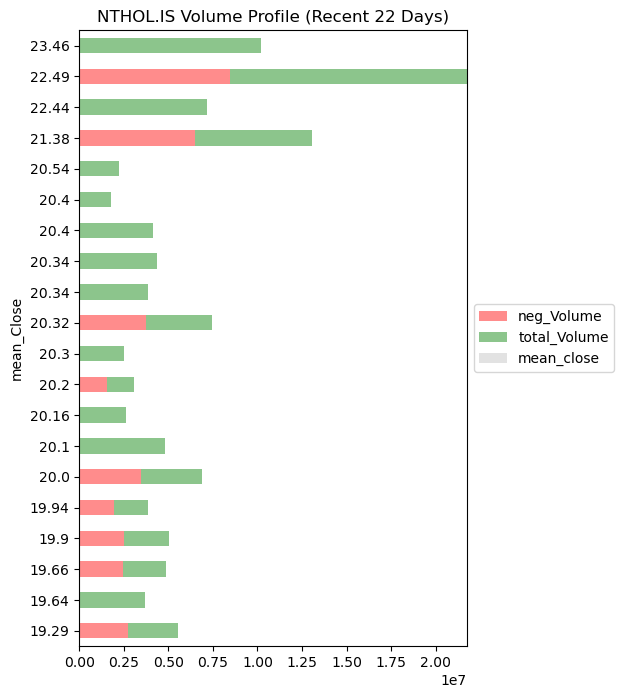

In [45]:
str1.VolumeProfile(f"{ticker}", startDate, endDate, '1d', range = 22, width = 20)

In [46]:
ticker = 'THYAO'
df = getBalanceSheet(writeExcel=False, stock = ticker, exchange="USD", language="ENG")

In [14]:
layout = go.Layout(
        title = f'{ticker} Balance Sheet',
        yaxis = dict(title='USD'),
        xaxis = dict(title='Quarter'),
        showlegend = True,
        legend = dict(
            x = 1.01, y = 1, traceorder='normal',
            bgcolor='#E2E2E2',
            bordercolor='black',
            borderwidth=2),
        width=1800,
        height=600)

fig = go.Figure(layout=layout)

for i in df.index.to_list():
    fig.add_trace(
        go.Scatter(
            x = df.columns,
            y = df.loc[i],
            name = i
        )
    )


fig.show()

[*********************100%%**********************]  1 of 1 completed


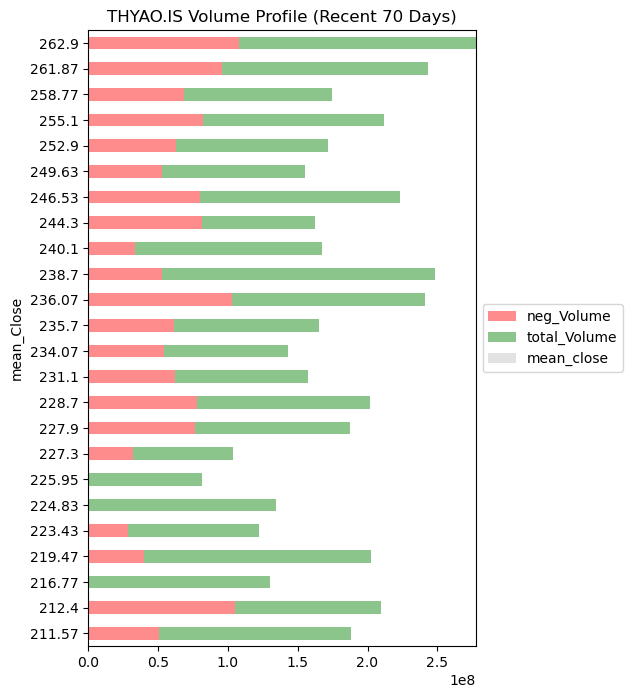

In [48]:
str1.VolumeProfile(f"{ticker}.IS", startDate, endDate, '1d', range = 70, width = 24)

# Crypto Trading
#### Crypto Trading using top 100 coins and Negative Divergence Signals

In [143]:
import requests

url = 'https://web-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
coinlist = []
for start in range(1, 20000, 5000):

    params = {
        'start': start,
        'limit': 5000,
    }

    r = requests.get(url, params=params)
    data = r.json()
    
    for number, item in enumerate(data['data']):
        coinlist.append(item['symbol'])
        # print(f"{start+number:4} | {item['symbol']:5} | {item['date_added'][:10]}")

In [167]:
coinlist_spl = coinlist[500:1000]
coinlist_spl = [f'{coin}-USD' for coin in coinlist_spl]
endDate2 = dt.datetime.now() - dt.timedelta(days = 1)
str2 = Technical_Analysis(ticker_list=coinlist_spl, start=startDate, end=endDate2, interval = '1d')
str2.RSI_Divergence_Negative(price = 'High', pivot_window = 10, RSI_short_length = 22, RSI_long_length = 66)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


1 Failed download:
['MULTI-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-28 08:56:22.978099 -> 2023-11-09 09:51:02.048117)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BIGTIME-USD']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['TOKEN-USD']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['LADYS-USD']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['OPTI-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-28 08:56:22.978099 -> 2023-11-09 09:51:02.048117)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['ALT-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-28 08:56:22.978099 -> 2023-11-09 09:51:02.048117)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['BAD-USD']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['STRX-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-28 08:56:22.978099 -> 2023-11-09 09:51:02.048117)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HDN-USD']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['HERO-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-28 08:56:22.978099 -> 2023-11-09 09:51:02.048117)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['PEPE2.0-USD']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['DC-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-28 08:56:22.978099 -> 2023-11-09 09:51:02.048117)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['VEXT-USD']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['DG-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-28 08:56:22.978099 -> 2023-11-09 09:51:02.048117)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['UX-USD']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['DUST-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-28 08:56:22.978099 -> 2023-11-09 09:51:02.048117)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['LMWR-USD']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['PROPC-USD']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['$MONG-USD']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['SHIA-USD']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['CPR-USD']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-06-28 08:56:22.978099 -> 2023-11-09 09:51:02.048117)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [145]:
R_more = -0.5
R_less = 0
change_more = -100
change_less = 100
rsi_divergence_less = 0
price_divergence_more = 0
macdh_more = -0.5

res2 = str2.DivergenceList_negative_watchlist(RSI_EOT_diff_more = R_more, RSI_EOT_diff_less = R_less, change_more=change_more, change_less = change_less, pivot_window=10,
                                             rsi_divergence_less = rsi_divergence_less, price_divergence_more = price_divergence_more, rsi_break=False, macdh_more = macdh_more)[0]
tickers2 = res2.index.to_list()
# meanReturns, covMatrix = ef.getData(tickers, start = startDate, end = endDate)
res2

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Portfolio today Return:  0.006172938955484581


,Divergence,RSI Divergence Ratio,Price Divergence Ratio,RSI_22_Date1,RSI_22_Date2,RSI_22_now,End_of_RSI_Down_Trend,RSI_66,Price_Date1,Price_Date2,Date1,Date2,Date_Last,MACDh,MFI_22,Change,Volatility,RSI_EOT_Ratio
Tickers,,,,,,,,,,,,,,,,,,
BLZ-USD,1,-0.106157,0.852558,81.772078,73.091402,59.664712,60.404261,55.279988,0.116100,0.215082,2023-08-13,2023-09-19,2023-11-09,-0.002304,69.338414,-0.122693,0.068684,-0.012243
PEG-USD,1,-0.098578,0.185897,83.625965,75.382292,67.435035,71.260455,69.838234,0.038333,0.045459,2023-09-26,2023-10-26,2023-11-09,0.000114,56.474443,-0.016827,0.959169,-0.053682
LQTY-USD,1,-0.054250,0.368765,80.329927,75.972036,50.521412,70.742567,51.676965,1.512309,2.069995,2023-10-11,2023-10-25,2023-11-09,-0.052561,58.134492,0.011029,0.069872,-0.285841
USDJ-USD,1,-0.042674,0.002984,60.415999,57.837806,51.546619,56.333861,51.137373,1.130745,1.134119,2023-09-19,2023-10-23,2023-11-09,-0.000812,57.540751,-0.000757,0.006621,-0.084980
USDC-USD,1,-0.032121,0.000184,56.978547,55.148357,47.421425,50.801656,50.343171,1.000489,1.000673,2023-10-04,2023-10-15,2023-11-09,-0.000013,42.007840,-0.000078,0.001731,-0.066538
AVINOC-USD,1,-0.030496,0.001706,59.235901,57.429443,46.044755,55.941771,48.836086,0.182295,0.182606,2023-09-28,2023-10-23,2023-11-09,-0.001338,46.032918,0.140156,0.153637,-0.176916
AOG-USD,1,-0.023659,0.002279,56.042632,54.716710,50.983463,53.125605,51.351794,0.632323,0.633764,2023-10-11,2023-10-25,2023-11-09,-0.000303,50.168222,-0.001748,0.030454,-0.040322
UIP-USD,1,-0.023074,4.485123,97.573496,95.322062,88.511298,92.897441,87.787142,0.207733,1.139441,2023-10-04,2023-10-21,2023-11-09,-0.008727,63.240769,-0.008775,3.136709,-0.047215
VEGA-USD,1,-0.022223,0.028795,59.565625,58.241890,52.638203,57.390917,51.122574,1.395169,1.435343,2023-10-10,2023-10-29,2023-11-09,-0.013449,47.093829,0.039919,0.061593,-0.082813


In [166]:
ticker = 'VEGA-USD'
graph_data = str2.getData(f"{ticker}", startDate + dt.timedelta(days = 300), endDate + dt.timedelta(days = 0), SMA = [5, 9, 20, 50, 100, 200], EMA = [9], interval = '1d')
Candle_graph(df = graph_data, date1 = res2.loc[ticker, 'Date1'], date2 = res2.loc[ticker, 'Date2'])

[*********************100%%**********************]  1 of 1 completed


# Backtest of the algorithm
#### *RSI_Divergence_Negative_multipledates* function is used to test the RSI Negative Divergence strategy. We are looking for the end of RSI Negative Divergence as a signal for long position

In [8]:
ticker_list = pd.read_excel("tickers_bist100.xlsx")
ticker_list = ticker_list.values.tolist()
ticker_list = [item for sublist in ticker_list for item in sublist]
# ticker_list = ticker_list[21:45]

endDate = dt.datetime.now() - dt.timedelta(days = 1)
startDate = endDate - dt.timedelta(days = 500)

db = 5
bt = Backtest(ticker_list, startDate, endDate)
results = bt.backtest_df(dateback=db)

bt.backtest_return(RSI_more = 0, RSI_less = 0.02, change_more=0)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


1 Failed download:
['ASTOR.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['EUREN.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IMASM.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KCAER.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MIATK.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['YEOTK.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(1.0015789835076583, [1, 1, 1, 1.0015789835076583, 1.0015789835076583])

In [7]:
ticker_list = pd.read_excel("tickers_bist100.xlsx")
ticker_list = ticker_list.values.tolist()
ticker_list = [item for sublist in ticker_list for item in sublist]
# ticker_list = ticker_list[21:45]

endDate = dt.datetime.now() - dt.timedelta(days = 1)
startDate = endDate - dt.timedelta(days = 500)

db = 5
bt2 = Backtest(ticker_list, startDate, endDate)
results2 = bt2.backtest_df(dateback=db)

bt2.backtest_return(RSI_more = -0.02, RSI_less = 0.02, change_more=-0.1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


1 Failed download:
['ASTOR.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['EUREN.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['IMASM.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['KCAER.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['MIATK.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['YEOTK.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(0.9736668671356822,
 [0.981203007518797,
  0.981203007518797,
  0.9351309357336265,
  0.9446911951251017,
  0.9736668671356822])

In [102]:
str1.RSI_Divergence_Negative_func(['ALMAD', 'ANELE'], price = 'High', start = startDate, end = np.busday_offset(dt.datetime.now().date(),-db+1).astype(dt.datetime),
                                  interval='1d', pivot_window = 20, RSI_short_length = 22, RSI_long_length = 66)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Divergence,RSI Divergence Ratio,Price Divergence Ratio,RSI_22_Date1,RSI_22_Date2,RSI_22_now,End_of_RSI_Down_Trend,RSI_66,Price_Date1,Price_Date2,Date1,Date2,Date_Last,Change,Volatility,RSI_EOT_Ratio
Tickers,,,,,,,,,,,,,,,,
ALMAD,1,-0.165133,0.014359,86.927080,72.572544,57.063597,54.353324,59.222623,9.75,9.89,2023-07-24,2023-08-29,2023-10-10,0.099045,0.039988,0.049864
ANELE,1,-0.155243,0.067456,84.885569,71.707680,66.044909,58.969054,59.939046,8.45,9.02,2023-07-24,2023-09-04,2023-10-10,-0.022706,0.037532,0.119993
